Автоэнкодеры можно обучить убирать шум из данных: для этого надо на вход подавать зашумленные данные и на выходе сравнивать с данными без шума:

L(x, f(g(\hat x))),

где \hat x — зашумленные данные.

В Keras можно оборачивать произвольные операции из нижележащего фреймворка в Lambda слой. Обращаться к операциям из tensorflow или theano можно через модуль backend.

Создадим модель, которая будет зашумлять входное изображение, а избавлять от шума переобучим какой-либо из уже созданных автоэнкодеров.

In [15]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print (f"x_train {x_train[:1]}")
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

x_train [[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126
   136 175  26 166 255 247 127   0   0   0   0]
  [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253
   253 225 172 253 242 195  64   0   0   0   0]
  [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253
   251  93  82  82  56  39   0   0   0   0   0]
  [  0   0   0   0   0   0   0  18 219 2

In [ ]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model

def create_dense_ae():
    # Размерность кодированного представления
    encoding_dim = 49

    # Энкодер
    # Входной плейсхолдер
    input_img = Input(shape=(28, 28, 1)) # 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности
    # Вспомогательный слой решейпинга
    flat_img = Flatten()(input_img)
    # Кодированное полносвязным слоем представление
    encoded = Dense(encoding_dim, activation='relu')(flat_img)
    
    # Декодер
    # Раскодированное другим полносвязным слоем изображение
    input_encoded = Input(shape=(encoding_dim,))
    flat_decoded = Dense(28*28, activation='sigmoid')(input_encoded)
    decoded = Reshape((28, 28, 1))(flat_decoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать как и слои
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [ ]:
encoder, decoder, autoencoder = create_dense_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
import keras.backend as K
from keras.layers import Lambda

batch_size = 16

def create_denoising_model(autoencoder):
    def add_noise(x):
        noise_factor = 0.5
        x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 28, 28, 1))
    noised_img = Lambda(add_noise)(input_img)

    noiser = Model(input_img, noised_img, name="noiser")
    denoiser_model = Model(input_img, autoencoder(noiser(input_img)), name="denoiser")
    return noiser, denoiser_model


noiser, denoiser_model = create_denoising_model(autoencoder)
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
denoiser_model.fit(x_train, x_train,
                   epochs=200,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_data=(x_test, x_test))

In [ ]:
decoder.save('decoder_denoise_200.h5')
encoder.save('encoder_denoise_200.h5')

In [ ]:
from keras.models import load_model
load = 0 # не работает так эта херня. надо все данные иметь сохраненные. шумные данные по формату не совпадает
# со входными картинками. их надо решейпить. 
# ValueError: Input 0 is incompatible with layer decoder: expected shape=(None, 49), found shape=(10, 28, 28, 1)
if load:
    batch_size = 16
    from keras.datasets import mnist
    import numpy as np

    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_test  = x_test .astype('float32') / 255.
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
    x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))
    decoder = load_model('decoder_denoise_200.h5')
    encoder = load_model('encoder_denoise_200.h5')

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

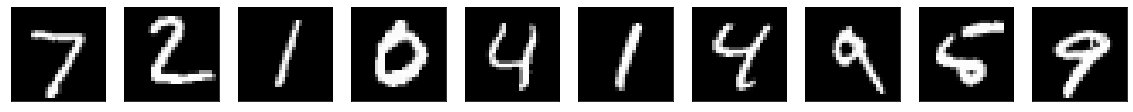

In [17]:
n = 10

imgs = x_test[:batch_size]
# noised_imgs = noiser.predict(imgs, batch_size=batch_size)
# encoded_imgs = encoder.predict(noised_imgs[:n],  batch_size=n)
# decoded_imgs = decoder.predict(encoded_imgs[:n], batch_size=n)

# plot_digits(imgs[:n], noised_imgs, decoded_imgs)
plot_digits(imgs[:n])

In [ ]:
encoded_imgs[:20]


In [ ]:
decoder = load_model('decoder_denoise_200.h5')
encoder = load_model('encoder_denoise_200.h5')
encoder.summary()